# Import libraries and data

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy import stats


from imblearn.pipeline import Pipeline as iPipe
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedStratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_curve, auc, plot_confusion_matrix, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from scipy.stats import chi2_contingency
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


import  warnings
warnings.simplefilter('ignore')

matplotlib.rcParams['figure.figsize'] = (10, 5)
matplotlib.rcParams['font.size'] = 13
plt.style.use('ggplot')
%matplotlib inline

# Colors
BLUE = '#008FD5'
RED = '#FF2700'
GREEN = '#77AB43'
YELLOW = '#FFDD33'
BLACK = '#040404'

# Random Seed
SEED = 42

In [ ]:
#Import data, Google Colab
import requests
from io import StringIO

#Read files from google drive shared link
def read_csv_gdrive(url):
  file_id = url.split('/')[-2]
  dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
  csv_raw = StringIO(requests.get(dwn_url).text)
  return pd.read_csv(csv_raw)

flights = read_csv_gdrive('https://drive.google.com/file/d/1KBdeem6RKrcqlW7PK33HysATsnSpM8UM/view?usp=sharing')
weather = read_csv_gdrive('https://drive.google.com/file/d/1OKD52UWjsAeOXXAHzI3g3DCfbpKzdIPf/view?usp=sharing')

### Data head

In [ ]:
flights.head()

,Airline,Flight_Number,Plane_ID,FlightDate,Origin_Airport,Destination_Airport,Flight_Distance,Scheduled_Departure_Time,Actual_Departure_Time,Departure_Delay_Minutes,Departure_Taxi,Departure_WheelsOff,Scheduled_Arrival_Time,Actual_Arrival_Time,Arrival_Delay_Minutes,Arrival_Taxi,Arrival_WheelsOn,Delay_Reason
0,TR,4135,GJLOAB,2019-12-01,IYF,HIX,678.0,1,103.0,62.0,15.0,118.0,127,219.0,52.0,7.0,212.0,LateAircraft
1,TR,3776,GDISCI,2019-12-01,HEN,HIX,1700.0,10,25.0,15.0,21.0,46.0,616,624.0,8.0,27.0,557.0,NaN
2,RO,4754,GHHWLL,2019-12-01,HIX,IZN,413.0,10,10.0,0.0,15.0,25.0,242,227.0,0.0,5.0,222.0,NaN
3,XM,5604,GBGWFC,2019-12-01,HIX,IZU,130.0,10,44.0,34.0,34.0,118.0,111,155.0,44.0,4.0,151.0,Weather
4,XM,5612,GBISBC,2019-12-01,HIX,LKF,258.0,10,234.0,144.0,26.0,300.0,132,358.0,146.0,6.0,352.0,Carrier


In [ ]:
weather.head()

,Unnamed: 0,airport,time,summary,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,ozone,precipType,precipAccumulation,time2
0,1,Highland,2019-11-30 00:00:00,Overcast,0.0000,0.00,37.30,32.11,32.47,0.82,1019.58,6.70,8.06,141.090120,1.00,0,10.0,309.69,NaN,NaN,2019-11-30 00:00:00
1,2,Highland,2019-11-30 01:00:00,Possible Drizzle,0.0018,0.35,37.74,33.16,32.10,0.80,1018.31,5.77,7.58,110.003815,0.95,0,10.0,309.09,rain,NaN,2019-11-30 01:00:00
2,3,Highland,2019-11-30 02:00:00,Possible Drizzle,0.0062,0.54,37.60,31.13,32.41,0.83,1017.91,8.04,8.57,112.053620,1.00,0,10.0,308.70,rain,NaN,2019-11-30 02:00:00
3,4,Highland,2019-11-30 03:00:00,Light Rain,0.0135,0.71,36.60,29.78,31.76,0.83,1016.64,8.90,9.84,103.033220,1.00,0,10.0,309.40,rain,NaN,2019-11-30 03:00:00
4,5,Highland,2019-11-30 04:00:00,Overcast,0.0007,0.06,36.65,31.12,32.41,0.85,1017.49,6.95,8.95,104.085209,1.00,0,10.0,311.82,rain,NaN,2019-11-30 04:00:00


### Data features

In [ ]:
flights.columns

Index(['Airline', 'Flight_Number', 'Plane_ID', 'FlightDate', 'Origin_Airport',
       'Destination_Airport', 'Flight_Distance', 'Scheduled_Departure_Time',
       'Actual_Departure_Time', 'Departure_Delay_Minutes', 'Departure_Taxi',
       'Departure_WheelsOff', 'Scheduled_Arrival_Time', 'Actual_Arrival_Time',
       'Arrival_Delay_Minutes', 'Arrival_Taxi', 'Arrival_WheelsOn',
       'Delay_Reason'],
      dtype='object')

In [ ]:
weather.columns

Index(['Unnamed: 0', 'airport', 'time', 'summary', 'precipIntensity',
       'precipProbability', 'temperature', 'apparentTemperature', 'dewPoint',
       'humidity', 'pressure', 'windSpeed', 'windGust', 'windBearing',
       'cloudCover', 'uvIndex', 'visibility', 'ozone', 'precipType',
       'precipAccumulation', 'time2'],
      dtype='object')

### Initialize custom functions

In [ ]:
def corr_heatmap(df):
  corr_matrix = df.corr()
  mask = np.zeros_like(corr_matrix)
  mask[np.triu_indices_from(mask)] = True
  plt.figure(figsize=(15, 9))
  with sns.axes_style("white"):
    sns.set_theme(style="whitegrid")
    sns.heatmap(corr_matrix, annot=True, cmap='PuOr', mask=mask)
    plt.show() # To remove the warning

In [ ]:
# function for viewing data on null values
def create_null_df(df):
  null_percentage = (df.isnull().sum() / df.shape[0]).sort_values(ascending=False)
  null = pd.DataFrame(null_percentage, columns=['perc_null'])
  null = null[null.perc_null > 0.0]
  feat_vals = [df[feat].unique() for feat in null.index]
  feat_dtype = [df[feat].dtype for feat in null.index]
  null['vals'] = feat_vals
  null['dtype'] = feat_dtype
  return null

In [ ]:
# plot distribution and print summary stats
def plot_dist(feature, color, df):
    plt.figure(dpi=100)
    sns.distplot(df[feature],color=color);
    print("Max value of {} is {}\nMin value of {} is {}\nMean value of {} is {}\nStd value of {} is {}\nMedian value of {} is {}".format(feature,df[feature].max(),feature,df[feature].min(),feature,df[feature].mean(),feature,df[feature].std(),feature,df[feature].median()));

In [ ]:
def pipe_feat_transformers(list_transformers):
  # Create pipeline of transformers (similar to make_pipeline)
  transformer_tuples = []
  for t in list_transformers:
    t_name = str(t).split('(')[0] #name of transformer
    transformer_tuples.append((t_name, t))
  return Pipeline(transformer_tuples)

def final_pipe(preprocessor, model):
  # Combine Column Transformer and model into final pipeline
  model_name = str(model).split('(')[0]
  steps = [('preprocessor', preprocessor), (model_name, model)]
  return Pipeline(steps)

def pipe_transforms_with_model(transform_dicts, model):
  # pipline for each unique set of feature transforms
  feature_transform_pipes = [pipe_feat_transformers(transform_dict['transforms']) for transform_dict in transform_dicts]
  
  # Create list of transformer pipeline tuples to pass into ColumnTransformer
  transformers_param = []
  for transform, ft_pipe in zip(transform_dicts, feature_transform_pipes):
    transformers_param.append((transform['name'], ft_pipe, transform['features']))
  
  preprocessor = ColumnTransformer(transformers=transformers_param, remainder='passthrough', n_jobs=-1)
  return final_pipe(preprocessor, model)

In [ ]:
# Function to plot ROC using test data
def plot_roc(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    plt.figure()
    sns.set_theme(style='whitegrid')
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve, auc= ' +str(auc)[:5])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    return fpr, tpr, thresholds

In [ ]:
def tree_feature_importance(model, feature_names):
  # Feature importance - top 10
  importances = model.feature_importances_
  std = np.std([tree.feature_importances_ for tree in model.estimators_],
              axis=0)
  indices = np.argsort(importances)[::-1][:10]

  # Print the feature ranking
  print("Feature ranking:")

  for f in range(10):
      print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

  # Plot the impurity-based feature importances of the forest
  plt.figure()
  sns.set_theme(style='whitegrid')
  plt.title("Feature importances")
  plt.bar(range(10), importances[indices],
          color="r", yerr=std[indices], align="center")
  plt.xticks(range(10), indices)
  plt.xlim([-1, 10])
  plt.show()

In [ ]:
# Get feature names from column transfomer
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
  
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

# Data Processing for Flights

#### Data Correctness

Confusion on how these variables were calculated. Need to speak to stakeholders on how to correct the data

In [ ]:
# Departure_Delay_Minutes
# Actual_Departure_Time - Scheduled_Departure_Time = Departure_Delay_Minutes
(flights.Actual_Departure_Time - flights.Scheduled_Departure_Time == flights.Departure_Delay_Minutes).value_counts(normalize=True)

False    0.774597
True     0.225403
dtype: float64

In [ ]:
# Average error in Departure_Delay_Minutes
np.mean(np.abs((flights.Actual_Departure_Time - flights.Scheduled_Departure_Time) - flights.Departure_Delay_Minutes))

25.764835767257

In [ ]:
# Arrival_Delay_Minutes
# Actual_Arrival_Time - Scheduled_Arrival_Time = Arrival_Delay_Minutes
(flights.Actual_Arrival_Time - flights.Scheduled_Arrival_Time == flights.Arrival_Delay_Minutes).value_counts(normalize=True)

False    0.787145
True     0.212855
dtype: float64

In [ ]:
# Average error in Arrival_Delay_Minutes
np.mean(np.abs((flights.Actual_Arrival_Time - flights.Scheduled_Arrival_Time) - flights.Arrival_Delay_Minutes))

369.44878100778146

In [ ]:
# Departure_WheelsOff
# Actual_Departure_Time + Departure_Taxi = Departure_WheelsOff
(flights.Actual_Departure_Time + flights.Departure_Taxi == flights.Departure_WheelsOff).value_counts(normalize=True)

True     0.628196
False    0.371804
dtype: float64

In [ ]:
# Actual Arrival Time
# Arrival_WheelsOn + Arrival_Taxi = Actual_Arrival_Time 
(flights.Arrival_WheelsOn + flights.Arrival_Taxi == flights.Actual_Arrival_Time).value_counts(normalize=True)

True     0.833072
False    0.166928
dtype: float64

In [ ]:
# Average error in Actual_Arrival_Time
np.mean(np.abs((flights.Arrival_WheelsOn + flights.Arrival_Taxi) - flights.Actual_Arrival_Time))

15.693249478444928

#### Recalculate features based on findings under Data Correctness

In [ ]:
# Recalculate Actual_Arrival_Time
flights.Actual_Arrival_Time = flights.Arrival_WheelsOn + flights.Arrival_Taxi

In [ ]:
# Recalculate Departure_Delay_Minutes
flights.Departure_Delay_Minutes = flights.Actual_Departure_Time - flights.Scheduled_Departure_Time 
flights.Departure_Delay_Minutes = flights.Departure_Delay_Minutes.apply(lambda x: x if x >= 0 else 0)

In [ ]:
# Recalculate Arrival_Delay_Minutes
flights.Arrival_Delay_Minutes = flights.Actual_Arrival_Time - flights.Scheduled_Arrival_Time
flights.Arrival_Delay_Minutes = flights.Arrival_Delay_Minutes.apply(lambda x: x if x >= 0 else 0)

#### Excluded Features

Remove identifiers and predictors that give information about the prediction (data we would not know before-hand). 

**Question**

* When are these predictions being made?
* Is this simply retrospective analysis to understand why delays are happening or will there be action taken on flights with high probability of delay?



In [ ]:
flight_identifiers = ['Plane_ID']
flight_leakage = ['Delay_Reason', 'Departure_Delay_Minutes', 'Arrival_Delay_Minutes', 'Actual_Arrival_Time']
flight_unneeded = ['Departure_WheelsOff', 'Departure_Taxi'] # Actual Departure Time precedes wheels off and does not include taxi time

flights_excluded_cols = flight_identifiers + flight_leakage + flight_unneeded

#### Null values

In [ ]:
create_null_df(flights)

,perc_null,vals,dtype
Delay_Reason,0.785576,"[LateAircraft, nan, Weather, Carrier, NAS, Sec...",object


There are flights with nan Delay_Reason that are actually delayed flights. Need to clean this up to distinguish 'unreported' delayed reasons from 'Not Applicable' (i.e. non-delayed flights)

In [ ]:
flights[(flights.Delay_Reason.isnull()) & (flights['Departure_Delay_Minutes'] > 0.0)].Departure_Delay_Minutes.describe()

count    9803.000000
mean       15.732735
std        30.198807
min         1.000000
25%         3.000000
50%         8.000000
75%        17.500000
max      2348.000000
Name: Departure_Delay_Minutes, dtype: float64

##### Mapping delay reasons

After research, delay reason of "NAS" turns out is due to weather. The weather category is for extreme weather that typically results in cancellations. 

https://www.bts.gov/topics/airlines-and-airports/understanding-reporting-causes-flight-delays-and-cancellations#:~:text=Delays%20or%20cancellations%20coded%20%22NAS,delays%20were%20due%20to%20weather.

Will map reason NAS -> Inclement Weather and Weather -> Extreme Weather


In [ ]:
def map_delay_reason(x):
  if x['Delay_Reason'] is np.nan: # Impute null Delay_Reason
    if x['Departure_Delay_Minutes'] > 15.0: #defining the delayed threshold at 15 min
      return 'Unreported' # null reason and delayed 
    else:
      return 'Not Applicable' # null reason and not delayed
  elif x['Delay_Reason'] == 'Weather':
    return 'Extreme Weather'
  elif x['Delay_Reason'] == 'NAS':
    return 'Inclement Weather'
  else:
    return x['Delay_Reason']


flights['Delay_Reason'] = flights[['Delay_Reason', 'Departure_Delay_Minutes']].apply(map_delay_reason, axis=1)

In [ ]:
flights['Delay_Reason'].value_counts()

Not Applicable       48839
LateAircraft          5780
Inclement Weather     4480
Carrier               3320
Unreported            2749
Extreme Weather        492
Security                 9
Name: Delay_Reason, dtype: int64

### Outliers

In [ ]:
# Get labels of numeric columns
numeric_feats = flights.dtypes[(flights.dtypes != "object")].index

In [ ]:
z = np.abs(stats.zscore(flights[numeric_feats]))
threshold = 3

# Features with outliers (3 std from mean)
numeric_feats[np.unique(np.where(z > 3)[1])]

Index(['Flight_Distance', 'Departure_Delay_Minutes', 'Departure_Taxi',
       'Arrival_Delay_Minutes', 'Arrival_Taxi'],
      dtype='object')

In [ ]:
flights_no_outliers = flights[numeric_feats][(z < 3).all(axis=1)]

### Create binary response variable for delayed

In [ ]:
# Use Departure_Delay_Minutes as response variable
flights['delayed'] = flights.Departure_Delay_Minutes.apply(lambda x: 1 if x >= 15 else 0)

### Convert Date/Time features for Departure

In [ ]:
# Create Scheduled Departure Date and Time feature
flights['Scheduled_Depature_Date_Time'] = flights[['FlightDate', 'Scheduled_Departure_Time']].apply(lambda x: x[0] + ' ' + str(x[1]).zfill(4), axis=1)
flights['Scheduled_Depature_Date_Time'] = pd.to_datetime(flights['Scheduled_Depature_Date_Time'])

# Extract new Date related features
flights['Day_of_Month'] = flights['Scheduled_Depature_Date_Time'].dt.day
flights['Day_Name'] = flights['Scheduled_Depature_Date_Time'].dt.day_name()

In [ ]:
# Bin time of day into part of the day
def map_part_day(s):
  if s.hour >= 1 and s.hour <= 3: 
    return 'redeye'
  if s.hour >= 4 and s.hour <= 7:
    return 'early morning'
  if s.hour >= 8 and s.hour <= 11:
    return 'late morning'
  if s.hour >= 12 and s.hour <= 15:
    return 'early afternoon'
  if s.hour >= 16 and s.hour <= 19:
    return 'evening'
  return 'night' # 8pm-12pm

flights['Part_Of_Day'] = flights.Scheduled_Depature_Date_Time.apply(map_part_day)

### Separate dataframes for HIX

In [ ]:
# flights out of highland
flights_hix = flights[flights.Origin_Airport == 'HIX'].copy()

### Create features for previous flight delay and airport

In [ ]:
flights_into_hix = flights[flights.Destination_Airport == 'HIX'][['Plane_ID', 'FlightDate', 'Scheduled_Arrival_Time', 'Departure_Delay_Minutes', 'Delay_Reason']]

In [ ]:
def find_previous_flight(hix_flight):
  # matching criteria for previous flight (Plane_ID, FlightDate, Arrival Time < Departure Time)
  criteria = (flights_into_hix.Plane_ID == hix_flight.Plane_ID) &\
                     (flights_into_hix.FlightDate == hix_flight.FlightDate) &\
                     (flights_into_hix.Scheduled_Arrival_Time < hix_flight.Scheduled_Departure_Time)
  
  # flights matching criteria
  matched = flights_into_hix[criteria]

  # If matches found, get most recent/closest (in time) flight
  if (matched.shape[0] > 0):
    depart_arrival_lags = hix_flight.Scheduled_Departure_Time - matched.Scheduled_Arrival_Time
    most_recent_flight_index = np.argmin(depart_arrival_lags)
    # return only previous flight's delay and delay reason
    return matched.iloc[most_recent_flight_index][['Departure_Delay_Minutes', 'Delay_Reason']]
  
  # otherwise, return 
  return np.array([0, 'Not Applicable'])

In [ ]:
most_recent_into_hix = flights_hix[['Plane_ID', 'FlightDate', 'Scheduled_Departure_Time']].apply(find_previous_flight, axis=1)

In [ ]:
flights_hix['Incoming_Flight_Delay'] = most_recent_into_hix.apply(lambda x: float(x[0]))
flights_hix['Incoming_Flight_Delay_Reason'] = most_recent_into_hix.apply(lambda x: x[1])

In [ ]:
flights_hix['Incoming_Flight_Delayed'] = flights_hix['Incoming_Flight_Delay'].apply(lambda x: 1 if x >= 15 else 0)

## EDA for Flights

<Figure size 600x400 with 0 Axes>

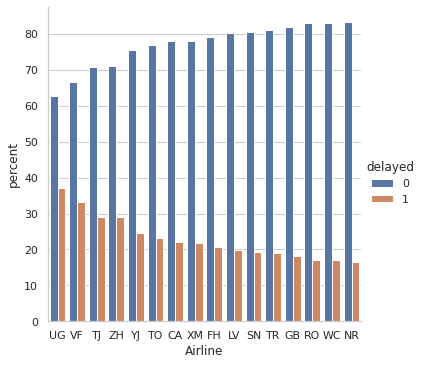

In [ ]:
# Percentage of Delayed Flights by Airline
x = 'Airline'
hue = 'delayed'
perc_df = flights.groupby(x)[hue].value_counts(normalize=True).mul(100).rename('percent').reset_index().sort_values(['delayed', 'percent'], ascending=False)
plt.figure(dpi=100)
sns.set_theme(style='whitegrid')
sns.catplot(data=perc_df, x=x, y='percent', hue=hue, kind='bar')

In [ ]:
# % of flights delayed by airline (Top 5)
perc_df.head()

,Airline,delayed,percent
21,UG,1,37.165775
23,VF,1,33.333333
15,TJ,1,29.151292
31,ZH,1,28.957529
29,YJ,1,24.586288


<Figure size 600x400 with 0 Axes>

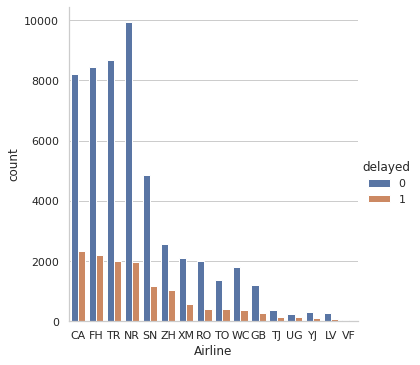

In [ ]:
# Delayed count by Airline
x = 'Airline'
hue = 'delayed'
counts_df = flights.groupby(x)[hue].value_counts().rename('count').reset_index().sort_values(['delayed', 'count'], ascending=False)
plt.figure(dpi=100)
sns.set_theme(style='whitegrid')
sns.catplot(data=counts_df, x=x, y='count', hue=hue, kind='bar')

Plot dist of Departure_Delay_Minutes. 

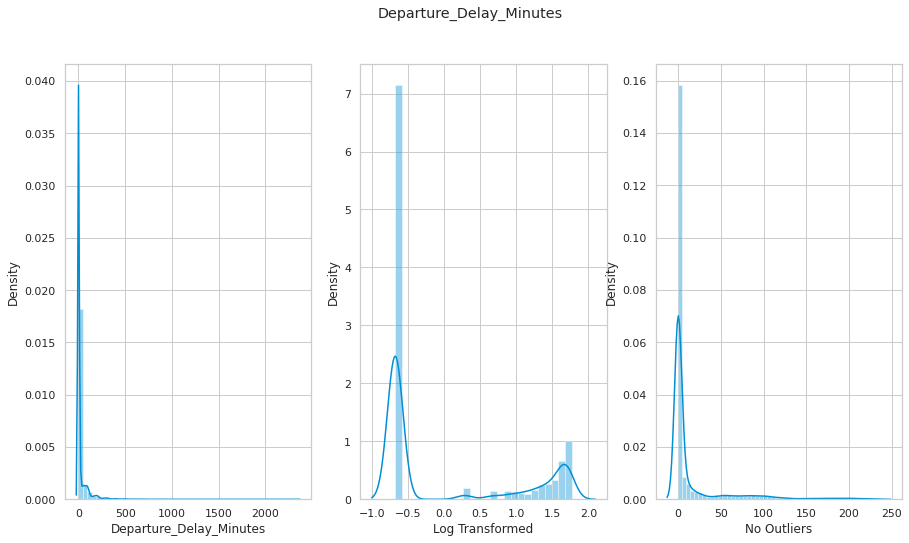

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,8))
fig.suptitle('Departure_Delay_Minutes')
sns.distplot(flights['Departure_Delay_Minutes'], color=BLUE, ax=ax1)
sns.set_theme(style='whitegrid')
sns.distplot(np.reshape(PowerTransformer().fit_transform(flights[['Departure_Delay_Minutes']]), 
                        flights['Departure_Delay_Minutes'].shape[0]), 
                        color=BLUE, ax=ax2, axlabel='Log Transformed')
sns.distplot(flights_no_outliers['Departure_Delay_Minutes'], color=BLUE, ax=ax3, axlabel='No Outliers')

Look at how many flights overall are delayed vs not delayed. Looks proportionally the same for HIX

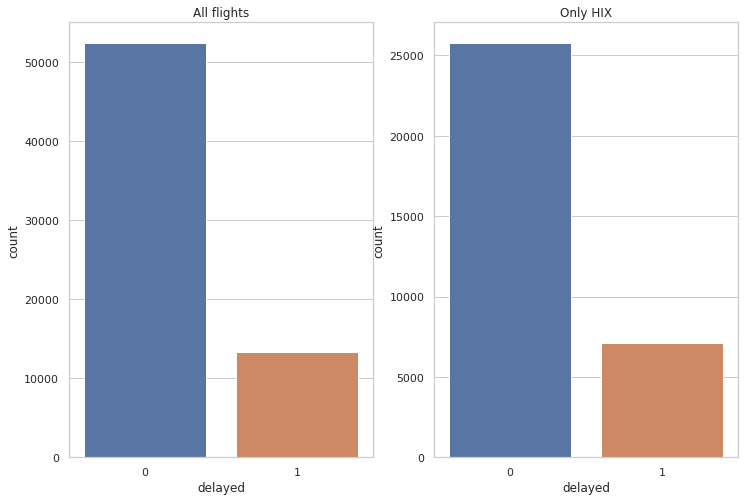

In [ ]:
# How many delayed vs on-time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
ax1.title.set_text('All flights')
ax2.title.set_text('Only HIX')
sns.set_theme(style='whitegrid')
sns.countplot(x= flights['delayed'], ax=ax1)
sns.countplot(x= flights_hix['delayed'], ax=ax2)

Overall percentage of flights delayed. Class imbalance here. Null Error Rate ~80% will provide a baseline.

In [ ]:
flights['delayed'].value_counts(normalize=True)

0    0.797835
1    0.202165
Name: delayed, dtype: float64

Flight distance seems to be very similar for delayed and not delayed flights

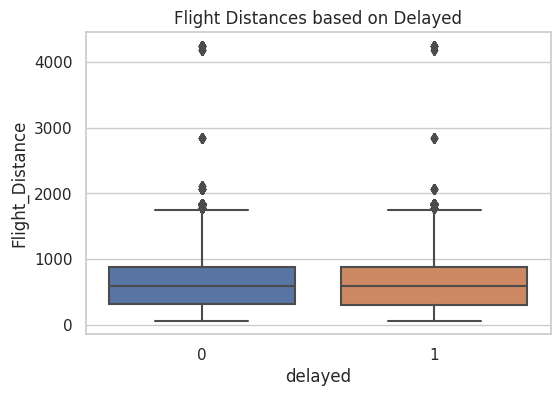

In [ ]:
# Flight distance on delay
sns.set_style("whitegrid")
plt.figure(dpi=100)
plt.title("Flight Distances based on Delayed")
sns.boxplot(x = flights_hix['delayed'],y = flights_hix['Flight_Distance'])

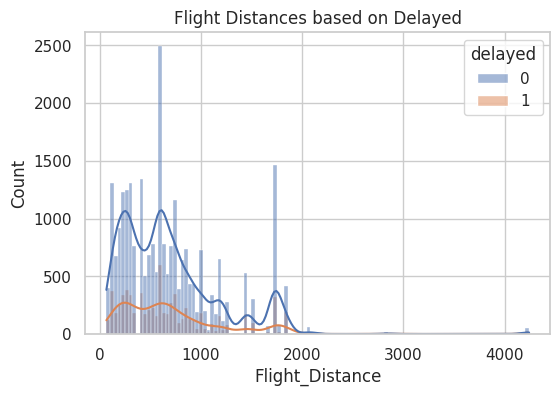

In [ ]:
sns.set_style("whitegrid")
plt.figure(dpi=100)
plt.title("Flight Distances based on Delayed")
sns.histplot(flights_hix, x ='Flight_Distance', hue='delayed', kde=True)

Not delayed incoming flight seems to be more informative then a delayed incoming flight

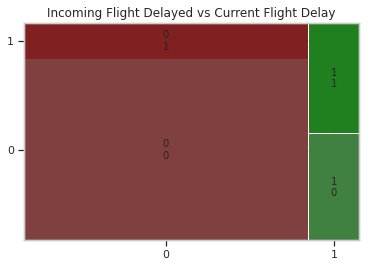

In [ ]:
sns.set_style("whitegrid")
mosaic(flights_hix, ['Incoming_Flight_Delayed', 'delayed'], title ='Incoming Flight Delayed vs Current Flight Delay')
plt.show()

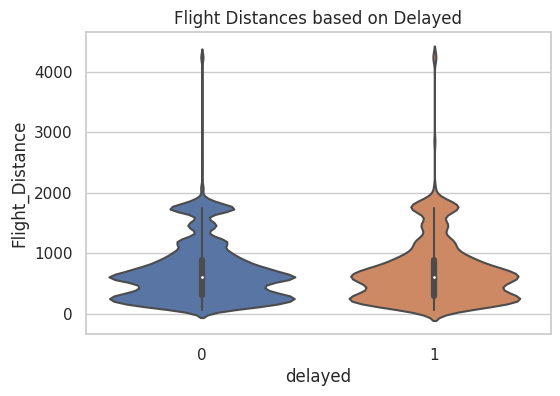

In [ ]:
sns.set_style("whitegrid")
plt.figure(dpi=100)
plt.title("Flight Distances based on Delayed")
sns.violinplot(data=flights_hix, x='delayed', y ='Flight_Distance')

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

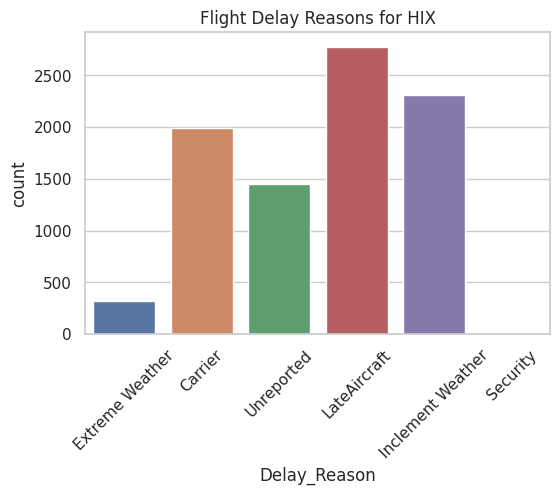

In [ ]:
# Delay reasons
sns.set_style("whitegrid")
plt.figure(dpi=100)
plt.title("Flight Delay Reasons for HIX")
sns.countplot(x= flights_hix[flights_hix['Delay_Reason'] != 'Not Applicable'].Delay_Reason)
plt.xticks(rotation=45)

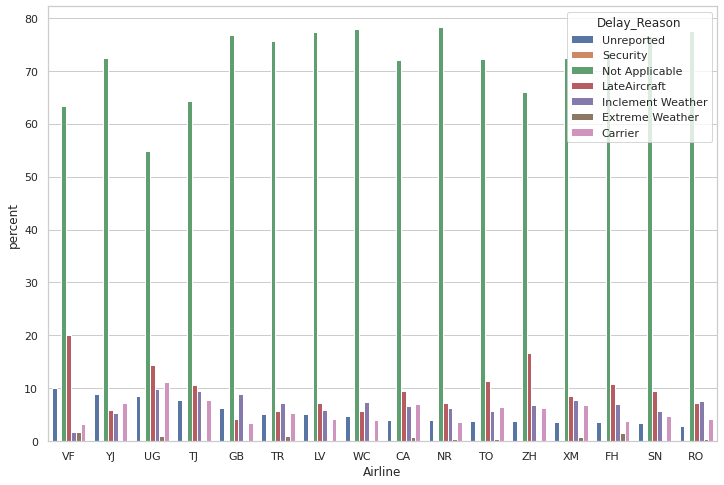

In [ ]:
# Percentage of Delayed Flights by Airline
x = 'Airline'
hue = 'Delay_Reason'
perc_df = flights.groupby(x)[hue].value_counts(normalize=True).mul(100).rename('percent').reset_index().sort_values([hue, 'percent'], ascending=False)
sns.set_theme(style='whitegrid')
plt.figure(figsize=(12,8))
sns.barplot(data=perc_df, x=x, y='percent', hue=hue)

A lot of outliers wrt Departure_Delay_Minutes

No handles with labels found to put in legend.


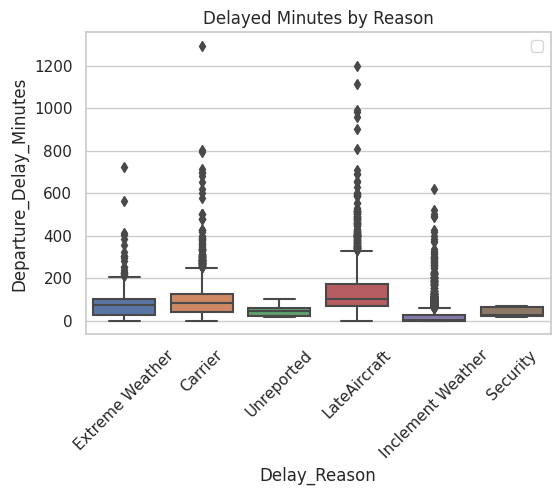

In [ ]:
sns.set_style("whitegrid")
plt.figure(dpi=100)
plt.title("Delayed Minutes by Reason")
sns.boxplot(x= 'Delay_Reason', y='Departure_Delay_Minutes', data= flights_hix[flights_hix['Delay_Reason'] != 'Not Applicable'])
plt.xticks(rotation=45)
plt.legend(loc='upper right')

That seems to be a lot of variability in delay reason based on airline. Will consider splittiing model by delay reason. 

# Data Processing for Weather

In [ ]:
create_null_df(weather)

,perc_null,vals,dtype
precipAccumulation,0.947266,"[nan, 0.005, 0.0476, 0.0415, 0.0058, 0.0055, 0...",float64
precipType,0.794271,"[nan, rain, snow]",object


Check if null values correspond to 'None' i.e. no precipitation

In [ ]:
weather[weather.precipAccumulation.isnull()][['precipIntensity', 'precipType', 'precipProbability']]

,precipIntensity,precipType,precipProbability
0,0.0000,NaN,0.00
1,0.0018,rain,0.35
2,0.0062,rain,0.54
3,0.0135,rain,0.71
4,0.0007,rain,0.06
...,...,...,...
1531,0.0000,NaN,0.00
1532,0.0000,NaN,0.00
1533,0.0000,NaN,0.00
1534,0.0000,NaN,0.00


Impute 'None' for precipType and impute 0 for precipAccumulation

In [ ]:
weather['precipAccumulation'].fillna(value=0.0, inplace=True)
weather['precipType'].fillna(value='None', inplace=True)

## Convert and create Date/Time features

In [ ]:
# time and time2 are the same
(weather.time == weather.time2).unique()

array([ True])

In [ ]:
# delete unncessary columns
del weather['time2']
del weather['Unnamed: 0']

In [ ]:
# Create new feature that is the time feature converted to datetime object
weather['Date_Time'] = pd.to_datetime(weather['time'])

## EDA for Weather

Drop highly correlated features in weather

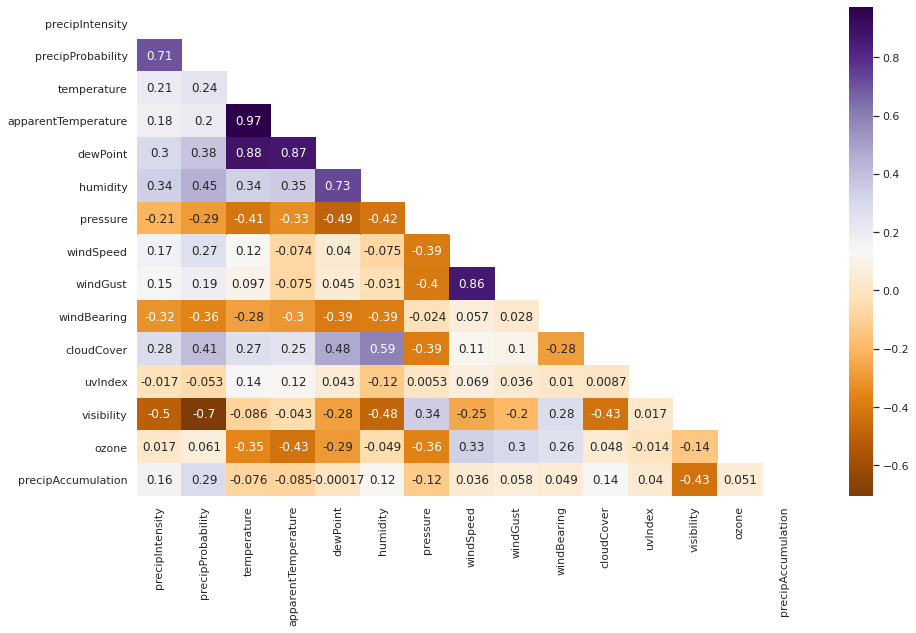

In [ ]:
corr_heatmap(weather)

In [ ]:
# Exclude some highly correlated columns and identifier
weather_excluded_cols = ["apparentTemperature", "dewPoint", "precipAccumulation", "precipProbability", "windGust"]

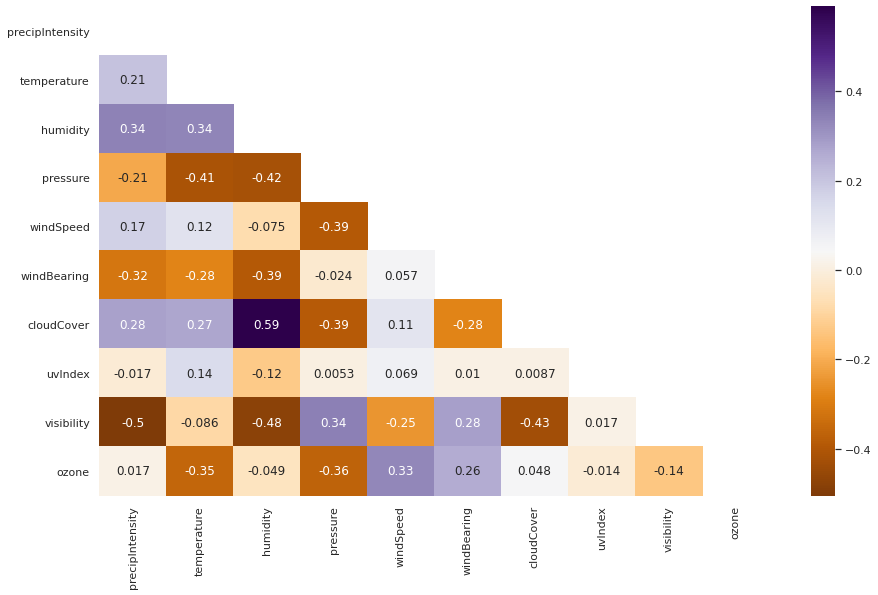

In [ ]:
corr_heatmap(weather.drop(weather_excluded_cols, axis=1))

This looks a lot better. Reduced much of the redundant data

# Merge Flights and Weather

In [ ]:
# temp df for merge
flights_hix_temp = flights_hix[flights_hix.Origin_Airport == 'HIX'].copy()
weather_hix_temp = weather[weather['airport'] == 'Highland'].copy()

In [ ]:
# Merge both dfs
flights_weather = pd.merge(flights_hix_temp, weather_hix_temp, 
                           how='left', 
                           left_on=[flights_hix_temp['Scheduled_Depature_Date_Time'].dt.date, flights_hix_temp['Scheduled_Depature_Date_Time'].dt.hour], 
                           right_on=[weather_hix_temp['Date_Time'].dt.date, weather_hix_temp['Date_Time'].dt.hour])

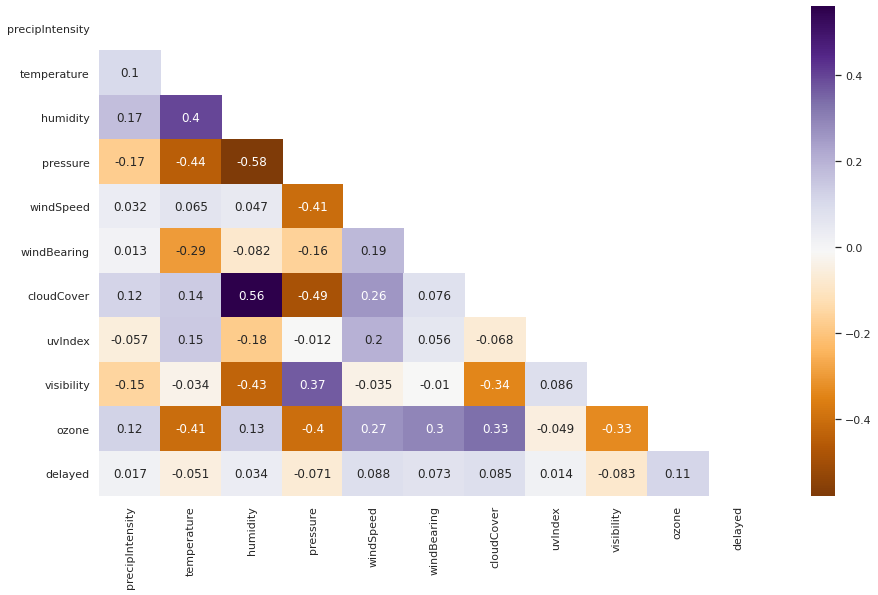

In [ ]:
# No strong linear relationship with numerical weather features and delayed
weather_and_delayed = [col for col in weather if col not in weather_excluded_cols] + ['delayed']
corr_heatmap(flights_weather[weather_and_delayed])

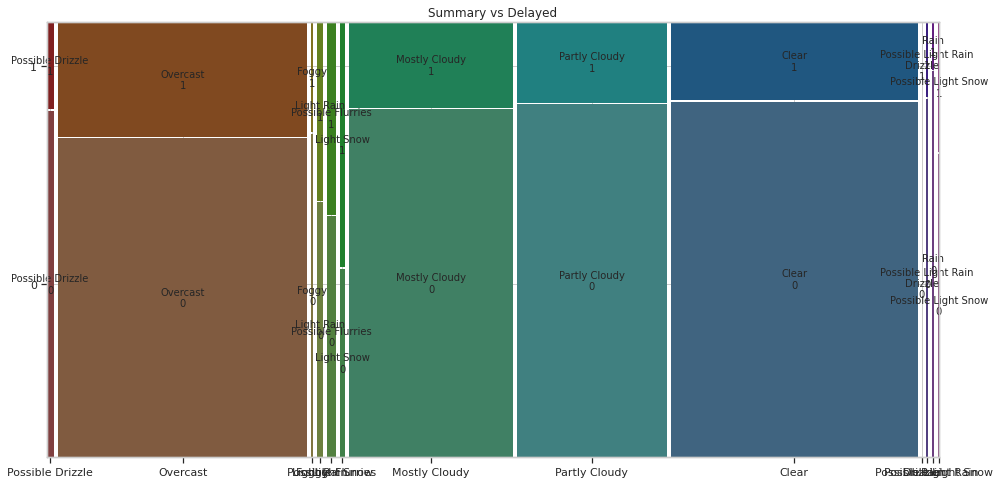

In [ ]:
# Summary doesn't seem to have anything too predictive of delay
sns.set_style("whitegrid")
plt.rc("figure", figsize=(16,8))
mosaic(flights_weather, ['summary', 'delayed'], title ='Summary vs Delayed')
plt.show()

# Modeling - Predict Delayed

Finalize feature set

In [ ]:
fw_features = ['Airline',
 'Flight_Distance',
 'delayed',
 'Day_of_Month',
 'Day_Name',
 'Part_Of_Day',
 'Incoming_Flight_Delay',
 'Incoming_Flight_Delay_Reason',
 'Incoming_Flight_Delayed',
 'summary',
 'precipIntensity',
 'temperature',
 'humidity',
 'pressure',
 'windSpeed',
 'windBearing',
 'cloudCover',
 'uvIndex',
 'visibility',
 'ozone',
 'precipType']

Class imbalance. Will address by resampling or adjusting class weights

In [ ]:
flights_weather.delayed.value_counts(normalize=True)

0    0.784104
1    0.215896
Name: delayed, dtype: float64

Split data for train and test

In [ ]:
X = flights_weather[fw_features].drop('delayed', axis=1)
y = flights_weather['delayed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=SEED)

Get labels for numeric/categoric features

In [ ]:
# Get labels of numeric columns
numeric_feats = X_train.dtypes[X.dtypes != "object"].index
# Get labels of categoric columns 
categoric_feats = X_train.dtypes[X.dtypes == "object"].index

####Random Forest

              precision    recall  f1-score   support

 not delayed       0.83      0.90      0.86      8479
     delayed       0.48      0.34      0.40      2366

    accuracy                           0.78     10845
   macro avg       0.65      0.62      0.63     10845
weighted avg       0.75      0.78      0.76     10845

Feature ranking:
1. Flight_Distance (0.286683)
2. Incoming_Flight_Delay (0.083439)
3. ozone (0.037945)
4. windBearing (0.037904)
5. temperature (0.036751)
6. OneHotEncoder__x3_Not Applicable (0.036070)
7. windSpeed (0.035708)
8. pressure (0.035416)
9. humidity (0.030171)
10. cloudCover (0.028332)


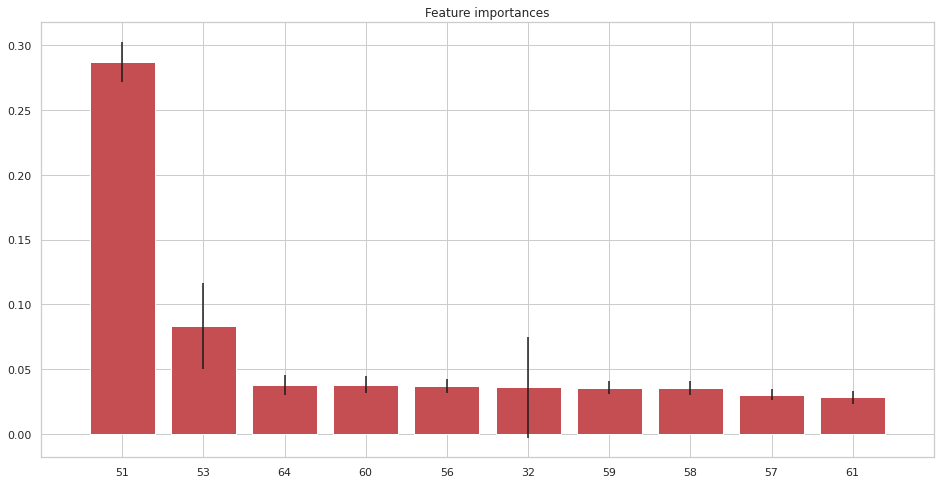

In [ ]:
transform_dicts = [{
      'name': 'catergoric_transforms', 
      'transforms': [OneHotEncoder(handle_unknown='ignore')], 
      'features': categoric_feats
}]

pipe = pipe_transforms_with_model(transform_dicts, RandomForestClassifier(oob_score=True,
                             max_features="sqrt",
                             random_state = SEED, class_weight='balanced'))

# fit model and predict
pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test)

# print accuracy report
print(classification_report(y_test, predictions, target_names=['not delayed', 'delayed']))

# feature importance
model = pipe.named_steps['RandomForestClassifier']
feature_names = get_feature_names(pipe.named_steps['preprocessor'])
tree_feature_importance(model, feature_names)

### Logistic Regression

              precision    recall  f1-score   support

 not delayed       0.86      0.80      0.83      8479
     delayed       0.44      0.54      0.49      2366

    accuracy                           0.75     10845
   macro avg       0.65      0.67      0.66     10845
weighted avg       0.77      0.75      0.76     10845



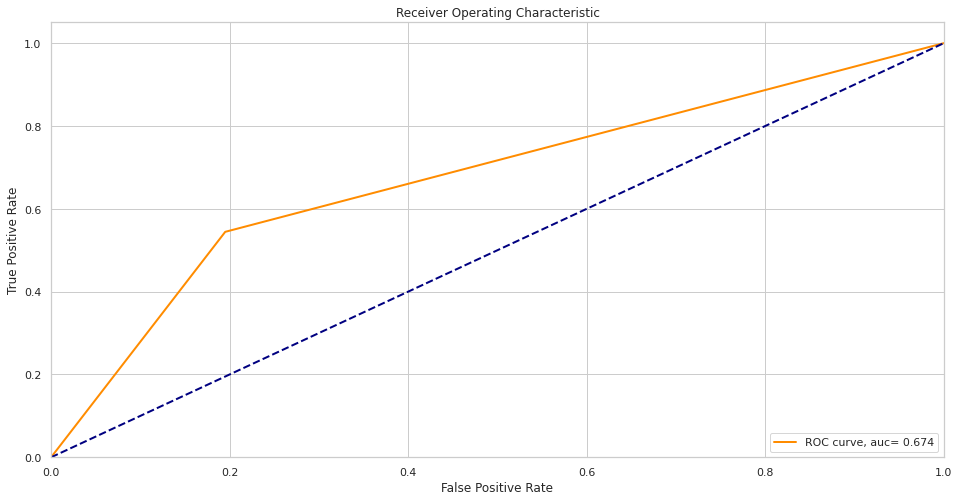

[('OneHotEncoder__x3_Unreported', -1.5232896746113755),
 ('OneHotEncoder__x3_Inclement Weather', 0.8024371365882705),
 ('OneHotEncoder__x3_Extreme Weather', 0.6209671747319232),
 ('OneHotEncoder__x0_UG', 0.6201367772384225),
 ('OneHotEncoder__x4_Light Snow', 0.5575101579216938),
 ('OneHotEncoder__x4_Light Rain', 0.5496969315550716),
 ('OneHotEncoder__x0_ZH', 0.539524832969318),
 ('OneHotEncoder__x4_Clear', -0.4670460809817986),
 ('OneHotEncoder__x0_RO', -0.4604311752372901)]

In [ ]:
transform_dicts2 = [{
      'name': 'catergoric_transforms', 
      'transforms': [OneHotEncoder(handle_unknown='ignore')], 
      'features': categoric_feats
  }, {
      'name': 'num_transforms', 
      'transforms': [StandardScaler(), PowerTransformer()], 
      'features': numeric_feats
  }]

pipe2 = pipe_transforms_with_model(transform_dicts2, LogisticRegression(penalty='l2', class_weight='balanced'))

# fit model and predict
pipe2.fit(X_train, y_train)
predictions2 = pipe2.predict(X_test)

# print accuracy report
print(classification_report(y_test, predictions2, target_names=['not delayed', 'delayed']))

# ROC
fpr, tpr, thresholds = plot_roc(pipe2, X_train, y_train, X_test, y_test)

# feature importance
importance = pipe2.named_steps['LogisticRegression'].coef_[0]
# top 10 features by abs coef
feats = get_feature_names(pipe.named_steps['preprocessor'])
feat_coef = [(feat, coef) for feat, coef in zip(feats, importance)]
feat_coef.sort(key=lambda x: np.abs(x[1]), reverse=True)
feat_coef[:9]

### PCA Logistic Regression

In [ ]:
transform_dicts3 = [{
      'name': 'catergoric_transforms', 
      'transforms': [OneHotEncoder(handle_unknown='ignore')], 
      'features': categoric_feats
  }, {
      'name': 'num_transforms', 
      'transforms': [StandardScaler(), PowerTransformer()], 
      'features': numeric_feats
  }]

pca = pipe_transforms_with_model(transform_dicts3, PCA(n_components=15))
pca_logreg = Pipeline([('pca', pca), ('logreg', LogisticRegression(penalty='l2', class_weight='balanced'))])

# fit model and predict
pca_logreg.fit(X_train, y_train)
pca_logreg_pred = pca_logreg.predict(X_test)

# print accuracy report
print(classification_report(y_test, pca_logreg_pred, target_names=['not delayed', 'delayed']))

              precision    recall  f1-score   support

 not delayed       0.85      0.80      0.83      8479
     delayed       0.42      0.51      0.46      2366

    accuracy                           0.74     10845
   macro avg       0.64      0.66      0.64     10845
weighted avg       0.76      0.74      0.75     10845



# Modeling - Predict Delay Reason

In [ ]:
mult_class_df = flights_weather[fw_features + ['delayed']].copy()

In [ ]:
# unique Delay_Reason
flights_weather.Delay_Reason.unique()

array(['Not Applicable', 'Extreme Weather', 'Carrier', 'Unreported',
       'LateAircraft', 'Inclement Weather', 'Security'], dtype=object)

Remap Delay_Reason to the following:

* 0 = No delay
* 1 = Weather Delay
* 2 = Non-weather Delay

In [ ]:
def map_delay_reasons(reason):
  if reason == 'Extreme Weather' or reason == 'Inclement Weather':
    return 1
  if reason == 'Not Applicable':
    return 0
  return 2

# def map_delay_reasons(reason):
#   if reason == 'Extreme Weather':
#     return 3
#   if reason == 'Inclement Weather':
#     return 1
#   if reason == 'Not Applicable':
#     return 0
#   if reason == 'Carrier':
#     return 4
#   if reason == 'LateAircraft':
#     return 5
#   return 6

mult_class_df['Delay_Reason'] = flights_weather.Delay_Reason.apply(map_delay_reasons)

Select features for model

In [ ]:
features = ['Airline',
 'Flight_Distance',
 'Day_of_Month',
 'Day_Name',
 'Part_Of_Day',
 'Incoming_Flight_Delay',
 'Incoming_Flight_Delay_Reason',
 'Incoming_Flight_Delayed',
 'summary',
 'precipIntensity',
 'temperature',
 'humidity',
 'pressure',
 'windSpeed',
 'windBearing',
 'cloudCover',
 'uvIndex',
 'visibility',
 'ozone',
 'precipType']

In [ ]:
# Split input vs response
X = mult_class_df[features]
y = mult_class_df['Delay_Reason']

In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=SEED)

In [ ]:
# Get labels of numeric columns
numeric_feats = X_train.dtypes[X.dtypes != "object"].index
# Get labels of categoric columns 
categoric_feats = X_train.dtypes[X.dtypes == "object"].index

### LinearSVC

In [ ]:
transform_dicts_mc = [{
      'name': 'catergoric_transforms', 
      'transforms': [OneHotEncoder(handle_unknown='ignore')], 
      'features': categoric_feats
  }, {
      'name': 'num_transforms', 
      'transforms': [StandardScaler(), PowerTransformer()], 
      'features': numeric_feats
  }]

mc_pipe = pipe_transforms_with_model(transform_dicts_mc, LinearSVC(penalty='l2', multi_class='ovr', class_weight='balanced'))

# fit model and predict
mc_pipe.fit(X_train, y_train)
mc_predictions = mc_pipe.predict(X_test)

# print accuracy report
print(classification_report(y_test, mc_predictions))
print(confusion_matrix(y_test, mc_predictions))

y_binarized = y_test.apply(lambda x: 1 if x != 0 else 0)
mc_predictions_binarized = np.array([1 if pred != 0 else 0 for pred in mc_predictions])

print(classification_report(y_binarized, mc_predictions_binarized))
print(confusion_matrix(y_binarized, mc_predictions_binarized))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      7916
           1       0.28      0.25      0.27       837
           2       0.53      0.39      0.45      2092

    accuracy                           0.74     10845
   macro avg       0.54      0.51      0.52     10845
weighted avg       0.72      0.74      0.73     10845

[[7001  327  588]
 [ 489  210  138]
 [1077  204  811]]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      7916
           1       0.60      0.47      0.52      2929

    accuracy                           0.77     10845
   macro avg       0.71      0.67      0.69     10845
weighted avg       0.76      0.77      0.76     10845

[[7001  915]
 [1566 1363]]


### LDA

In [ ]:
mc_pipe = pipe_transforms_with_model(transform_dicts_mc, LinearDiscriminantAnalysis())

# fit model and predict
mc_pipe.fit(X_train, y_train)
mc_predictions = mc_pipe.predict(X_test)

# print accuracy report
print(classification_report(y_test, mc_predictions))
print(confusion_matrix(y_test, mc_predictions))

y_binarized = y_test.apply(lambda x: 1 if x != 0 else 0)
mc_predictions_binarized = np.array([1 if pred != 0 else 0 for pred in mc_predictions])

print(classification_report(y_binarized, mc_predictions_binarized))
print(confusion_matrix(y_binarized, mc_predictions_binarized))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86      7916
           1       0.37      0.16      0.22       837
           2       0.57      0.35      0.43      2092

    accuracy                           0.76     10845
   macro avg       0.58      0.48      0.50     10845
weighted avg       0.72      0.76      0.73     10845

[[7358  110  448]
 [ 593  133  111]
 [1242  119  731]]
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      7916
           1       0.66      0.37      0.48      2929

    accuracy                           0.78     10845
   macro avg       0.73      0.65      0.67     10845
weighted avg       0.76      0.78      0.76     10845

[[7358  558]
 [1835 1094]]
